# Overview 
This notebook is made to train the CNN model on FER 2013 dataset using ResNet18 which falls under transfer learning. Apart from transfer learning,this model also uses Adam optimizer and data augumentation technique for optimization. Also, it logs the train and validation loss & accuracy per epoch and reports final test accuracy.

## What is Transfer Learning?

* Transfer learning is a deep learning technique where a model trained on a large, general dataset (e.g., ImageNet with millions of images) is reused and adapted for a specific task with fewer data (like facial expression recognition).

* Instead of training a CNN from scratch (which requires huge datasets and compute), we leverage the pre-trained feature extractor and only fine-tune the final layers for the new task.

## 1. Import Libraries 
This is the first section of the code where all the required libraries from Pytorch are imported.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

## 2. Device Check 


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 3. Data Preparation
The second step is Data Transforms and DataLoaders where transforms are the steps used for generalization and normalization of the images accprding to the requirement of the model architecture before feeding them to the model while dataloaders are used to deliver the images in the batch for efficient training.

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]     
    )
])

## 4. Dataset & Dataloaders
Here, first of all the path is assigned to train and test dataset and the whole dataset is divided into three parts: train dataset, test dataset and validation data. After that, for training purpose, the small batches of 64 images are formed. The train dataset has the data for training, validation dataset for validation and the test dataset for final evaluation. Finaly, the size of all the datasets are printed along with the name of categories.

In [4]:
train_dataset = datasets.ImageFolder(root="/kaggle/input/fer2013/train", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/input/fer2013/test", transform=transform)

val_ratio = 0.15  
val_size = int(val_ratio * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                        pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(train_dataset.classes)

Train dataset size: 28709
Validation dataset size: 1076
Test dataset size: 6102
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## 5. Model Architecture
 Now, the model is loaded with ResNet18 with pre-tained weights and the final layer is replaced with 7 output layers as per the model requirement and finally the model is moved to GPU.

In [5]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.4),
    torch.nn.Linear(model.fc.in_features, 7)
)

model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 6. Training Setup and Training Loop
 Firstly, the cross entropy loss is calculated and the model is optimized using Adam Optimizer and the dynamic learning rate is scheduled. Then, the model is trained in loop for 15 epochs and all the calculated metrices are stored for plotting the curves later. Finally, the best model is saved as per the calculated loss and accuracy.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

epochs = 15
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,                        # peak LR
    steps_per_epoch=len(train_loader),  # batches per epoch
    epochs=epochs,
    anneal_strategy="cos"               # smoother decay (cosine)
)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}
best_val_acc = 0.0
best_val_loss = float("inf")

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step() 

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        current_lr = scheduler.get_last_lr()[0]
        history["lr"].append(current_lr)

        loop.set_postfix(loss=loss.item(), acc=100*correct/total, lr=current_lr)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{epochs}] Validation", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100*val_correct/val_total)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_acc.pth")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_loss.pth")

Epoch 1/15 Train Loss: 1.2760, Train Acc: 51.50% | Val Loss: 1.1719, Val Acc: 54.37%


Epoch 2/15 Train Loss: 1.2674, Train Acc: 52.33% | Val Loss: 2.5424, Val Acc: 36.34%


Epoch 3/15 Train Loss: 1.2936, Train Acc: 52.26% | Val Loss: 1.2913, Val Acc: 52.88%


Epoch 4/15 Train Loss: 1.2125, Train Acc: 55.49% | Val Loss: 1.2639, Val Acc: 51.95%


Epoch 5/15 Train Loss: 1.1226, Train Acc: 57.89% | Val Loss: 1.2164, Val Acc: 53.72%


Epoch 6/15 Train Loss: 1.0774, Train Acc: 59.91% | Val Loss: 1.1536, Val Acc: 57.16%


Epoch 7/15 Train Loss: 1.0383, Train Acc: 61.08% | Val Loss: 1.1118, Val Acc: 59.39%


Epoch 8/15 Train Loss: 1.0019, Train Acc: 62.42% | Val Loss: 1.0230, Val Acc: 61.90%


Epoch 9/15 Train Loss: 0.9677, Train Acc: 63.67% | Val Loss: 0.9816, Val Acc: 63.57%


Epoch 10/15 Train Loss: 0.9264, Train Acc: 65.18% | Val Loss: 1.0086, Val Acc: 61.34%


Epoch 11/15 Train Loss: 0.8709, Train Acc: 67.27% | Val Loss: 0.9630, Val Acc: 65.24%


Epoch 12/15 Train Loss: 0.8207, Train Acc: 69.12% | Val Loss: 0.9397, Val Acc: 66.73%


Epoch 13/15 Train Loss: 0.7578, Train Acc: 71.36% | Val Loss: 0.9117, Val Acc: 67.84%


Epoch 14/15 Train Loss: 0.7019, Train Acc: 73.94% | Val Loss: 0.9209, Val Acc: 66.91%


Epoch 15/15 Train Loss: 0.6730, Train Acc: 74.67% | Val Loss: 0.9202, Val Acc: 66.82%


## 7. Model Testing
 This code evaluates the trained model on the test set and prints the final test accuracy.

In [7]:
model.eval()
correct = 0
total = 0000

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 68.67%


## 8. Results Visualization
 Finally,the code is used to plot the accuracy and loss curves each as per the recorded metrices. Lastly,a batch of images is taken from test set for prediction and the first 8 images are displayed along with their true and predicted values where the green title potrays correct prediction and the red title potrays wrong prediction.

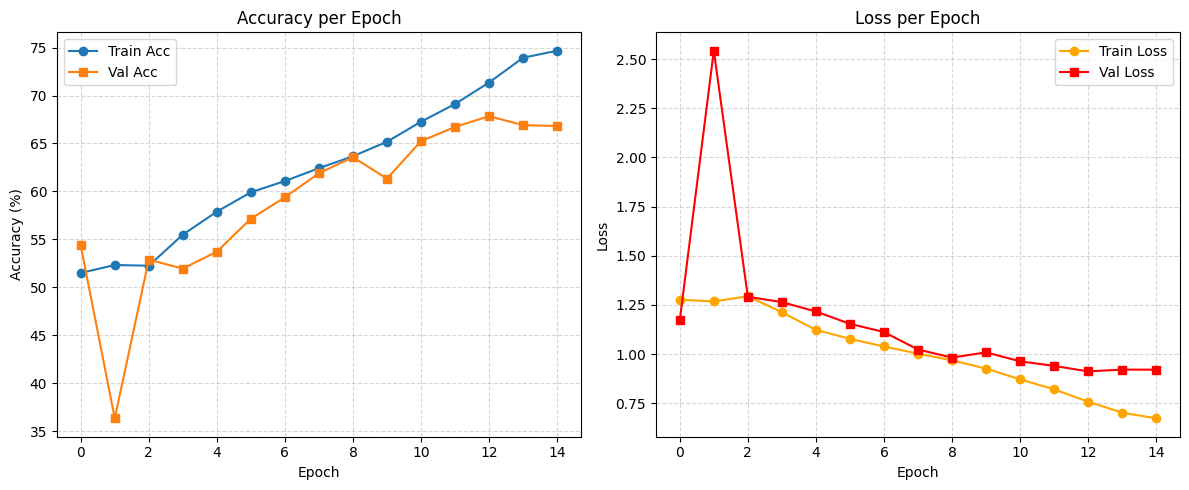

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history["train_acc"], label="Train Acc", marker='o')
ax1.plot(history["val_acc"], label="Val Acc", marker='s')
ax1.set(title="Accuracy per Epoch", xlabel="Epoch", ylabel="Accuracy (%)")
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

ax2.plot(history["train_loss"], label="Train Loss", marker='o', color='orange')
ax2.plot(history["val_loss"], label="Val Loss", marker='s', color='red')
ax2.set(title="Loss per Epoch", xlabel="Epoch", ylabel="Loss")
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

## 9. Predictions Visualization
Display sample test images with true vs predicted labels:

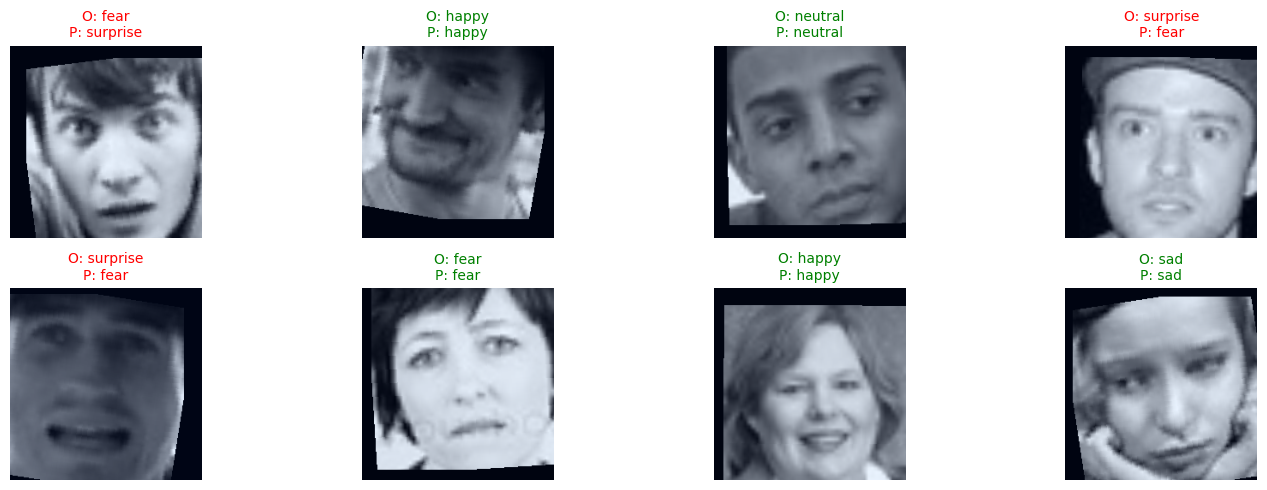

In [9]:

class_names = test_dataset.dataset.classes

import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

num_images = 8
plt.figure(figsize=(15, 5))

for i in range(num_images):
    img = images[i].cpu().permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    
    color = "green" if preds[i] == labels[i] else "red"
    
    plt.subplot(2, num_images//2, i+1)
    plt.imshow(img)
    plt.title(f"O: {class_names[labels[i]]}\nP: {class_names[preds[i]]}", color=color, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()